In [1]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D, LSTM
from keras.layers import Permute, Reshape
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics

2023-07-19 16:05:16.103224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:05:17.824653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [4]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    print('File Path : ',filepath)
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
# load all train
X_train, Y_train = load_dataset_group('train', 'dataset_uci/')
# load all test
X_test, Y_test = load_dataset_group('test', 'dataset_uci/')

# zero-offset class values
Y_train = Y_train - 1
Y_test = Y_test - 1
# one hot encode y
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

print('X_train.shape : ', X_train.shape)
print('Y_train.shape : ', Y_train.shape)
print('X_test.shape : ', X_test.shape)
print('Y_test.shape : ', Y_test.shape)

File Path :  dataset_uci/train/Inertial Signals/
File Path :  dataset_uci/test/Inertial Signals/
X_train.shape :  (7352, 128, 9)
Y_train.shape :  (7352, 6)
X_test.shape :  (2947, 128, 9)
Y_test.shape :  (2947, 6)


In [6]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = Y_train.shape[1]

# reshape into subsequences (samples, time steps, rows, cols, channels)
n_steps, n_length = 4, 32

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

In [7]:
verbose = 1
epochs = 30
batch_size = 20

# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
hist = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_test, Y_test), batch_size=batch_size, verbose=verbose)

# evaluate model
(loss, accuracy) = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))


2023-07-19 16:05:25.715009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 16:05:26.016296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-19 16:05:26.016620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/30


2023-07-19 16:05:32.929695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-19 16:05:34.583162: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 16:05:34.770717: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f6e1c00e470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 16:05:34.770765: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-07-19 16:05:34.826044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 16:05:35.178864: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 16:05:35.316135: I ./tensorflow/compiler/jit/device_comp

368/368 [==============================] - 18s 26ms/step - loss: 0.3744 - accuracy: 0.8494 - val_loss: 0.5492 - val_accuracy: 0.8741
Epoch 2/30
368/368 [==============================] - 8s 23ms/step - loss: 0.1531 - accuracy: 0.9396 - val_loss: 0.5538 - val_accuracy: 0.8853
Epoch 3/30
368/368 [==============================] - 9s 25ms/step - loss: 0.1256 - accuracy: 0.9486 - val_loss: 0.4864 - val_accuracy: 0.8873
Epoch 4/30
368/368 [==============================] - 9s 25ms/step - loss: 0.1161 - accuracy: 0.9504 - val_loss: 0.5349 - val_accuracy: 0.8778
Epoch 5/30
368/368 [==============================] - 8s 23ms/step - loss: 0.1072 - accuracy: 0.9559 - val_loss: 0.5279 - val_accuracy: 0.8965
Epoch 6/30
368/368 [==============================] - 8s 23ms/step - loss: 0.1019 - accuracy: 0.9559 - val_loss: 0.6389 - val_accuracy: 0.9084
Epoch 7/30
368/368 [==============================] - 8s 23ms/step - loss: 0.1063 - accuracy: 0.9561 - val_loss: 0.3339 - val_accuracy: 0.9074
Epoch 8/3

93/93 [==============================] - 0s 4ms/step


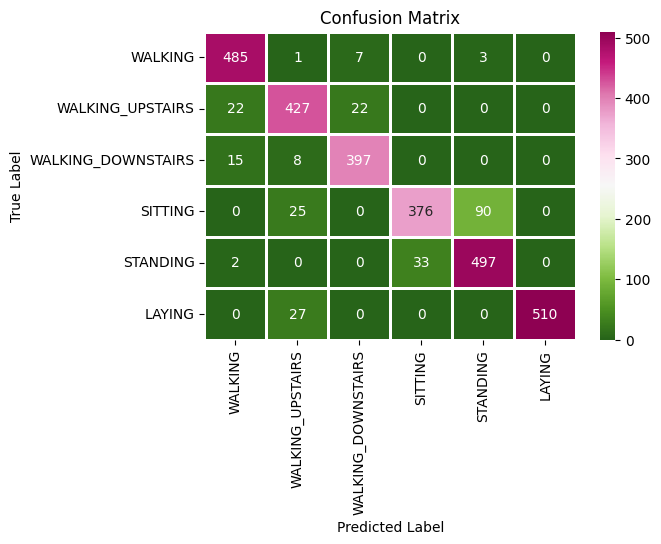

In [8]:
# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = ['WALKING',
          'WALKING_UPSTAIRS',
          'WALKING_DOWNSTAIRS',
          'SITTING',
          'STANDING',
          'LAYING']
y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(Y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='PiYG_r',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
from sklearn.metrics import accuracy_score

y_predict_train = model.predict(X_train).argmax(axis=1)
print("Train_accuracy is: ", accuracy_score(Y_train.argmax(axis=1), y_predict_train))

y_predict_test = model.predict(X_test).argmax(axis=1)
print("Test accuracy is: ", accuracy_score(Y_test.argmax(axis=1), y_predict_test))

230/230 [==============================] - 1s 5ms/step
Train_accuracy is:  0.9885745375408053
93/93 [==============================] - 0s 4ms/step
Test accuracy is:  0.9134713267729895


In [10]:
from sklearn import metrics

y_predict_test = model.predict(X_test).argmax(axis=1)
y_predict_train = model.predict(X_train).argmax(axis=1)


print("Test loss is: ", np.sqrt(metrics.mean_squared_error(Y_test.argmax(axis=1), y_predict_test)))
print("Train loss is: ", np.sqrt(metrics.mean_squared_error(Y_train.argmax(axis=1), y_predict_train)))

230/230 [==============================] - 1s 3ms/step
Test loss is:  0.5452077055073175
Train loss is:  0.10688995490313753


In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')